In [2]:
import sys
sys.path.append('../training_performance')

import platform
from pathlib import Path
from datetime import datetime, timedelta
import datajoint as dj
dj.blob.use_32bit_dims = True # necessary for pd.blob read

from create_trials_df import create_trials_df_from_dj
from create_days_df import create_days_df_from_dj, lazy_load_days_summary_df

from multiplot_summaries import *

import plot_utils as pu
import dj_utils as dju
import dir_utils as du

from plot_trials_info import *
from plot_days_info import *

import seaborn as sns
import pandas as pd
# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

[2023-09-13 20:18:57,161][INFO]: Connecting jbreda@bdata00.pni.princeton.edu:3306
[2023-09-13 20:18:57,396][INFO]: Connected jbreda@bdata00.pni.princeton.edu:3306


In [13]:
animals = [
    "R013",
    "R014",
    "R015",
    "R512",
    "R513",
]

df = create_trials_df_from_dj(animal_ids=animals)

fetched 53 sessions for R013 between 2023-07-14 and 2023-09-13
fetched 53 sessions for R014 between 2023-07-14 and 2023-09-13
fetched 53 sessions for R015 between 2023-07-14 and 2023-09-13
fetched 53 sessions for R512 between 2023-07-12 and 2023-09-13
fetched 53 sessions for R513 between 2023-07-12 and 2023-09-13


In [16]:
df = df.query("stage > 9").copy()
n_animals = len(df["animal_id"].unique())

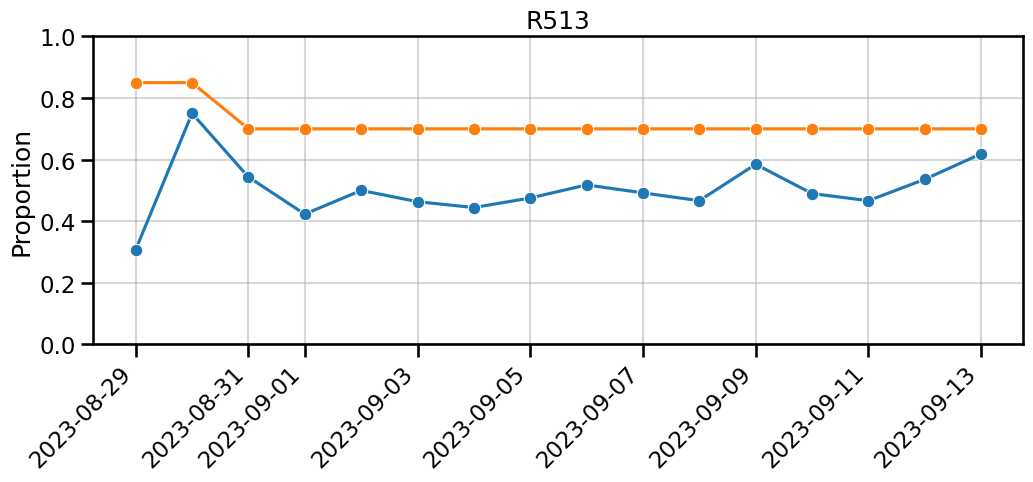

In [22]:
fig, ax = pu.make_fig()
plot_non_give_performance(
    df.query("animal_id == 'R013'"),
    ax=ax,
    title=animal,
    xaxis_label=True,
    legend=legend,
)

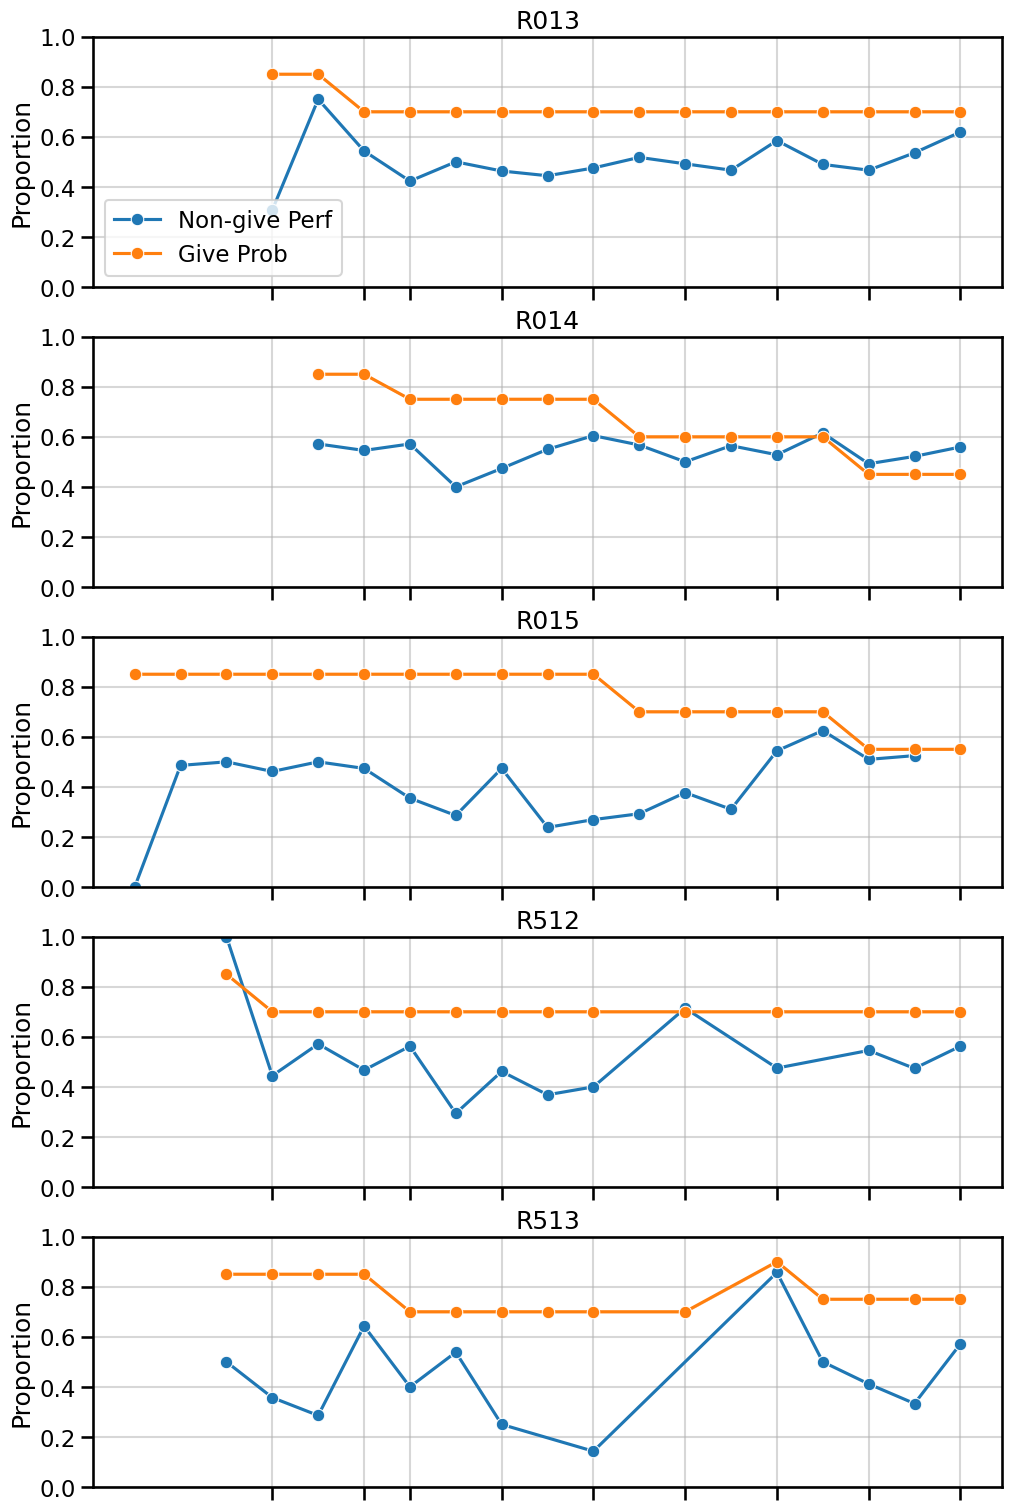

In [20]:
fig, ax = plt.subplots(
    n_animals,
    1,
    figsize=(
        10,
        3 * n_animals,
    ),
    constrained_layout=True,
    sharex=True,
)
for ii, (animal, sub_df) in enumerate(df.groupby("animal_id")):
    legend = False if ii != 0 else True
    label = False if ii != n_animals - 1 else True

    plot_non_give_performance(
        sub_df,
        ax=ax[ii],
        title=animal,
        xaxis_label=True,
        legend=legend,
    )

# _ = plt.xticks(rotation=90)

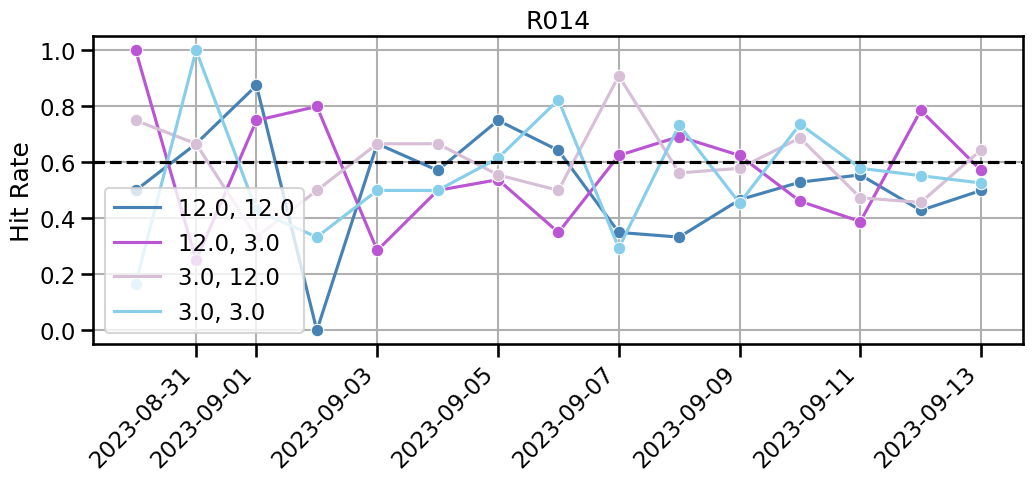

In [29]:
fig, ax = pu.make_fig()
plot_non_give_stim_performance(
    df.query("animal_id == 'R014'"),
    ax=ax,
    title="R014",
    xaxis_label=True,
)

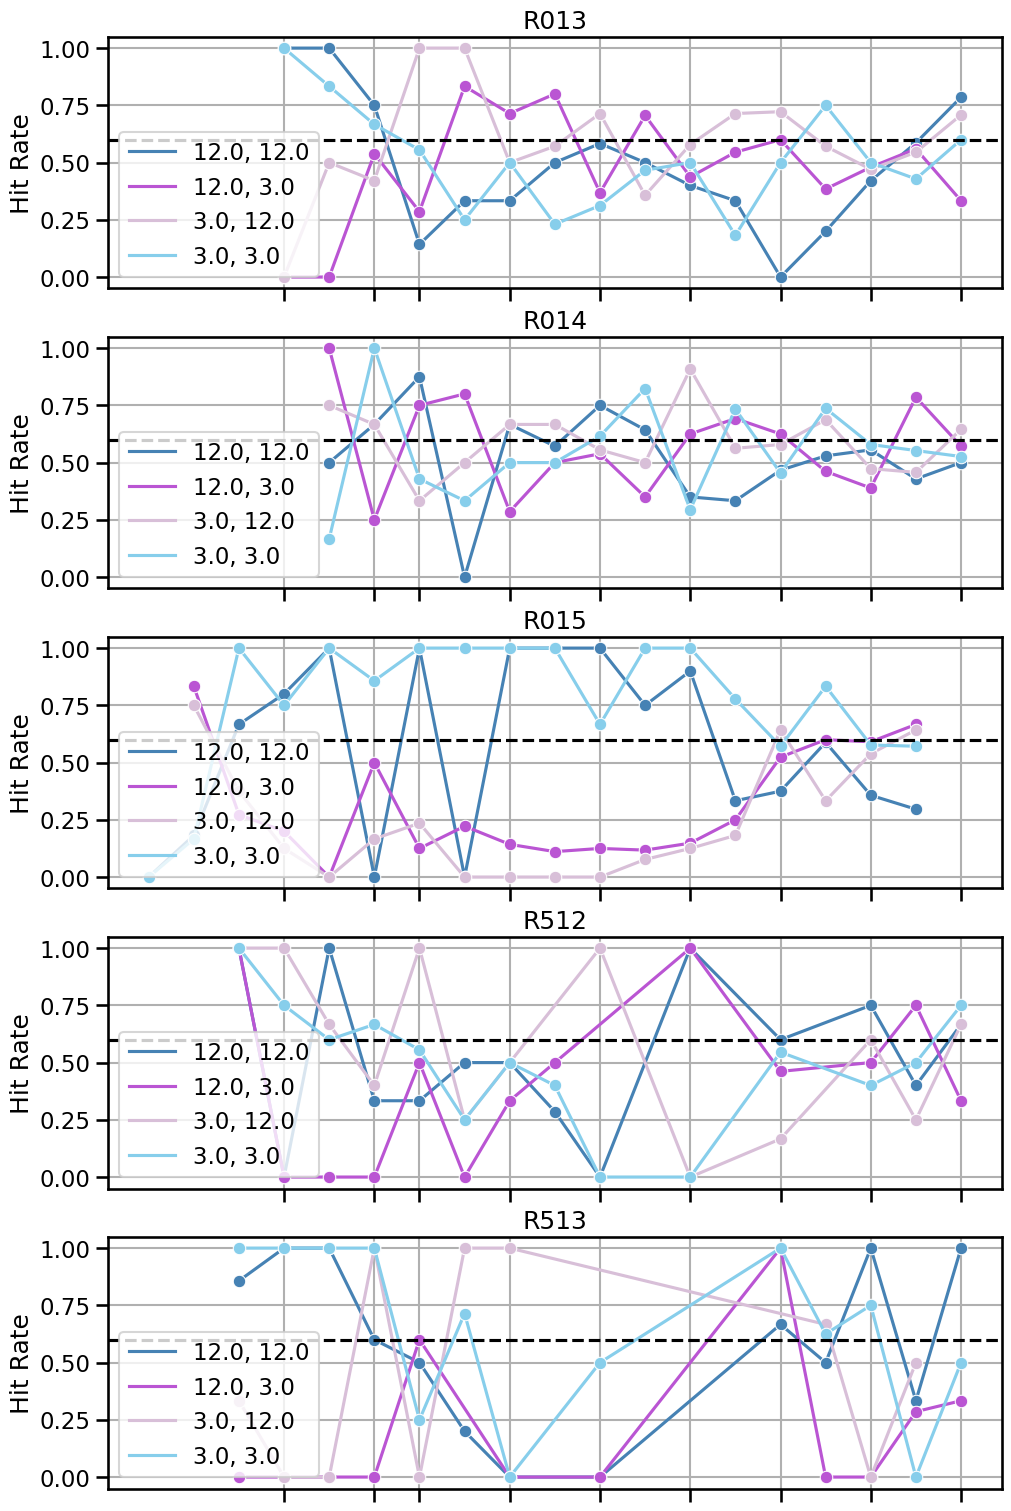

In [30]:
fig, ax = plt.subplots(
    n_animals,
    1,
    figsize=(
        10,
        3 * n_animals,
    ),
    constrained_layout=True,
    sharex=True,
)
for ii, (animal, sub_df) in enumerate(df.groupby("animal_id")):
    legend = False if ii != 0 else True
    label = False if ii != n_animals - 1 else True

    plot_non_give_stim_performance(
        sub_df,
        ax=ax[ii],
        title=animal,
        xaxis_label=True,
    )

# _ = plt.xticks(rotation=90)

In [51]:
GIVE_MAP = {
    "none": "green",
    "light": "#fcba03",
    "water_and_light": "cornflowerblue",
    "water": "cyan",
    "order": ["none", "light", "water_and_light", "water"],
}


def get_give_order(trial_give_column):
    """
    order the give types for plotting

    params:
    -------
    trial_give_columb: pandas.Series
        a column of the dataframe that contains the give
        type for a trial
    """
    return sorted(
        trial_give_column.unique(),
        key=lambda x: GIVE_MAP["order"].index(x)
        if x in GIVE_MAP["order"]
        else float("inf"),
    )


def get_give_colors(trial_give_column):
    """
    color the give types for plotting

    params:
    -------
    trial_give_column: pandas.Series
        a column of the dataframe that contains the give
        type for a trial
    """
    gives = get_give_order(trial_give_column)
    colors = [GIVE_MAP[give] for give in gives]
    return colors

In [46]:
get_give_colors(df["give_type_imp"])

['green', 'yellow', 'blue']

In [50]:
def plot_performance_by_give(trials_df, ax, title="", xaxis_label=True, legend=True):
    """
    generate a plot of hit rate for non-give trials

    params
    ------
    trials_df : pandas.DataFrame
        trials dataframe with columns `hits` and
        `give_type_imp` with trials as row index
    ax : matplotlib.axes.Axes
        axes to plot on
    title : str, (default = "")
        title of plot
    """

    sns.lineplot(
        data=trials_df,
        x="date",
        y="hits",
        marker="o",
        hue="give_type_imp",
        palette=get_give_colors(trials_df["give_type_imp"]),
        hue_order=get_give_order(trials_df["give_type_imp"]),
        ax=ax,
        errorbar=None,
    )

    # mark number of trials with give
    sns.lineplot(
        data=trials_df.query("give_type_imp == 'none'"),
        x="date",
        y="give_frac",
        marker="x",
        ax=ax,
        color="black",
    )

    # aethetics
    # pu.set_date_x_ticks(ax, xaxis_label)
    _ = ax.set(ylabel="Proportion", xlabel="", title=title, ylim=(0, 1))
    ax.grid(alpha=0.5)
    if legend:
        ax.legend(loc="lower left")
    else:
        ax.legend().remove()
    pu.set_date_x_ticks(ax, xaxis_label)

    return None

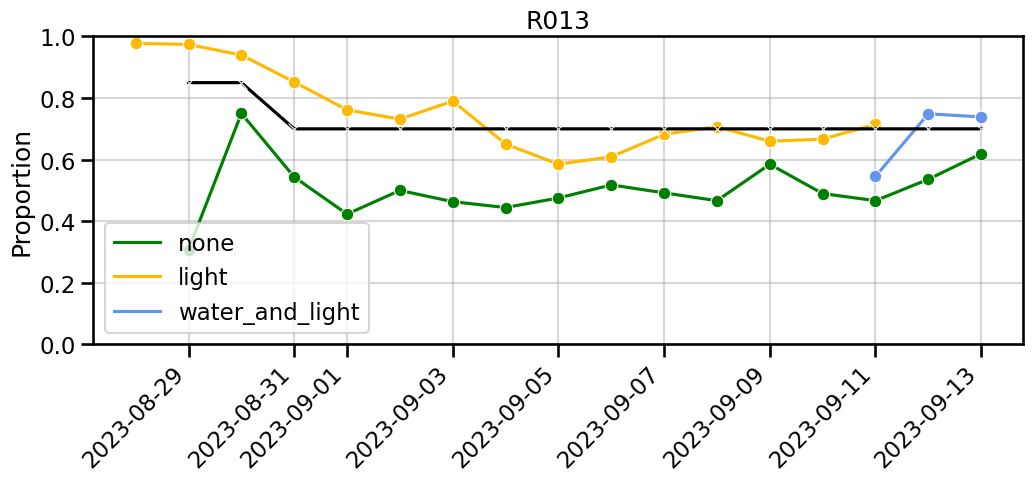

In [52]:
fig, ax = pu.make_fig()
plot_performance_by_give(
    df.query("animal_id == 'R013'"),
    ax=ax,
    title="R013",
    xaxis_label=True,
    legend=True,
)

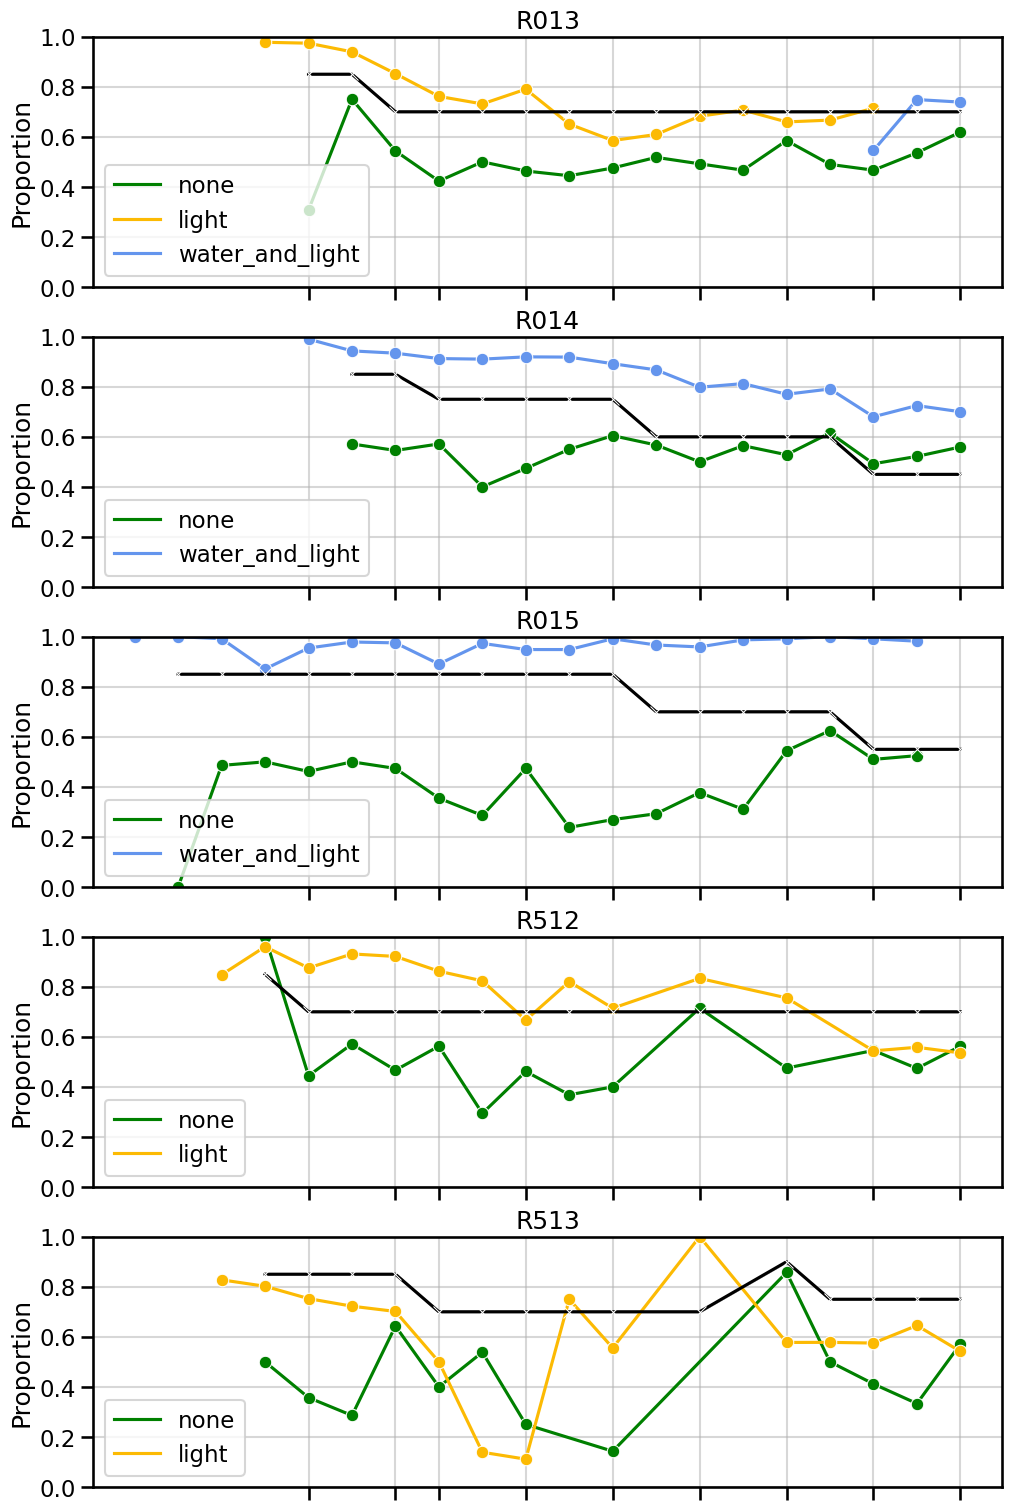

In [53]:
fig, ax = plt.subplots(
    n_animals,
    1,
    figsize=(
        10,
        3 * n_animals,
    ),
    constrained_layout=True,
    sharex=True,
)
for ii, (animal, sub_df) in enumerate(df.groupby("animal_id")):
    # legend = False if ii != 0 else True
    label = False if ii != n_animals - 1 else True

    plot_performance_by_give(
        sub_df,
        ax=ax[ii],
        title=animal,
        xaxis_label=True,
    )

# _ = plt.xticks(rotation=90)